In [1]:
import pandas as pd
# pd.options.mode.chained_assignment = None   # used to prevent throwing a warning
import numpy as np
from copy import deepcopy
from string import punctuation
from random import shuffle
import time
import matplotlib.pyplot as plt  
import seaborn as seabornInstance 
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
from collections import Counter
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [2]:
""" Tutorial function to process tweet file into a pandas df 
def ingest():
    data = pd.read_csv('./tweets.csv')
    data.drop(['ItemID', 'SentimentSource'], axis=1, inplace=True)
    data = data[data.Sentiment.isnull() == False]
    data['Sentiment'] = data['Sentiment'].map(int)
    data = data[data['SentimentText'].isnull() == False]
    data.reset_index(inplace=True)
    data.drop('index', axis=1, inplace=True)
    print 'dataset loaded with shape', data.shape    
    return data
"""

def ingest_reviews():
    """Fuction to read in the yelp json and convert to pandas df"""
    data = pd.read_json('yelp_academic_dataset_review.json', lines=True) # read json into pd.df
    data.drop(['review_id', 'user_id', 'business_id', 'useful', 'funny',
       'cool', 'date'], axis=1, inplace=True)     # drop useless data from frame to save space, time
    data = data[data.stars.isnull() == False]     # convert null values to False
    data['stars'] = data['stars'].map(int)     # map all star values to int()
    data = data[data.text.isnull() == False]     # convert null values to False
#     data.reset_index(inplace=True)    # create new index
#     data.drop('index', axis=1, inplace=True)     # delete old index
    print('dataset loaded with shape:', data.shape)    # display shape of data for confirmation
    return data

data = ingest_reviews()
data.head(5)

dataset loaded with shape: (8021122, 2)


,stars,text
0,2,"As someone who has worked with many museums, I..."
1,1,I am actually horrified this place is still in...
2,5,I love Deagan's. I do. I really do. The atmosp...
3,1,"Dismal, lukewarm, defrosted-tasting ""TexMex"" g..."
4,4,"Oh happy day, finally have a Canes near my cas..."


In [4]:
import os
os.getcwd()

'/work/jrk0200/corpora'

In [40]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install -U scikit-learn

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 6.8 MB 4.9 MB/s eta 0:00:01
  Using cached threadpoolctl-2.1.0-py3-none-any.whl (12 kB)
ERROR: persephone 0.3.2 has requirement numpy==1.14.0, but you'll have numpy 1.18.1 which is incompatible.
ERROR: persephone 0.3.2 has requirement scikit-learn==0.19.1, but you'll have scikit-learn 0.23.2 which is incompatible.
ERROR: persephone 0.3.2 has requirement scipy==1.0.0, but you'll have scipy 1.4.1 which is incompatible.
ERROR: persephone 0.3.2 has requirement tensorflow==1.4.1, but you'll have tensorflow 2.1.0 which is incompatible.
ERROR: h2o4gpu 0.3.2 has requirement future==0.16.0, but you'll have future 0.17.1 which is incompatible.
ERROR: h2o4gpu 0.3.2 has requirement numpy==1.16.1, but you'll have numpy 1.18.1 which is incompatible.
ERROR: h2o4gpu 0.3.2 has requirement pandas==0.24.1, but you'll have pandas 1.0.1 which is incompatible.
ERROR: h2o4gpu 0.3.2 has requir

In [3]:
analyzer = SentimentIntensityAnalyzer()

In [6]:
vs = analyzer.polarity_scores("VADER Sentiment looks interesting, I have high hopes!")
print(vs)

{'neg': 0.0, 'neu': 0.509, 'pos': 0.491, 'compound': 0.6996}


In [4]:
dev_set = data.head(500000)

In [12]:
def extract_neg(review):
    """Function to extract negative polarity score from Vader"""
    vs = analyzer.polarity_scores(review)
    
    return float(vs['neg'])


def extract_neu(review):
    """Function to extract neutral polarity score from Vader"""
    vs = analyzer.polarity_scores(review)
    
    return float(vs['neu'])


def extract_posit(review):
    """Function to extract positive polarity score from Vader"""
    vs = analyzer.polarity_scores(review)
    
    return float(vs['pos'])


def extract_comp(review):
    """Function to extract the compound polarity score from Vader"""
    vs = analyzer.polarity_scores(review)
    
    return float(vs['compound'])

def convert_results(prediction):
    if prediction >= 4.5:
        return 5.0
    elif prediction >= 3.5:
        return 4.0
    elif prediction >= 2.5:
        return 3.0
    elif prediction >= 1.5:
        return 2.0
    else:
        return 1.0

In [9]:
dev_set.head(10)


,stars,text,neg,neu,pos,comp,target
0,2,"As someone who has worked with many museums, I...",0.040,0.815,0.145,0.9794,2.0
1,1,I am actually horrified this place is still in...,0.110,0.850,0.040,-0.9690,1.0
2,5,I love Deagan's. I do. I really do. The atmosp...,0.025,0.758,0.217,0.9499,5.0
3,1,"Dismal, lukewarm, defrosted-tasting ""TexMex"" g...",0.151,0.808,0.041,-0.8283,1.0
4,4,"Oh happy day, finally have a Canes near my cas...",0.028,0.768,0.204,0.9887,4.0
5,5,This is definitely my favorite fast food sub s...,0.000,0.865,0.135,0.9136,5.0
6,5,"Really good place with simple decor, amazing f...",0.000,0.687,0.313,0.9673,5.0
7,5,"Awesome office and staff, very professional an...",0.000,0.596,0.404,0.9620,5.0
8,5,Most delicious authentic Italian I've had in t...,0.057,0.655,0.287,0.8818,5.0
9,4,I have been here twice. Very nice and laid bac...,0.039,0.763,0.198,0.9695,4.0


In [6]:
t1 = time.time()
print("Extracting Negative Scores from Vader")
dev_set['neg'] = dev_set['text'].progress_map(extract_neg)
print("Negative Loaded, {} total seconds elapsed.\nExtracting Neutral Scores from Vader".format(round(time.time()-t1, 3)))
dev_set['neu'] = dev_set['text'].progress_map(extract_neu)
print("Neutral Loaded, {} total seconds elapsed.\nExtracting Positive Scores from Vader".format(round(time.time()-t1, 3)))
dev_set['pos'] = dev_set['text'].progress_map(extract_posit)
print("Positive Loaded, {} total seconds elapsed.\nExtracting Compound Scores from Vader".format(round(time.time()-t1, 3)))
dev_set['comp'] = dev_set['text'].progress_map(extract_comp)
print("Compound Loaded, {} total seconds elapsed.\n".format(round(time.time()-t1, 3)))
dev_set['target'] = dev_set['stars'].map(float)


progress-bar:   0%|          | 46/500000 [00:00<18:23, 452.94it/s]

Extracting Negative Scores from Vader


progress-bar: 100%|██████████| 500000/500000 [11:06<00:00, 750.39it/s]
/cm/shared/utils/PYTHON/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
progress-bar:   0%|          | 47/500000 [00:00<17:46, 468.76it/s]

Negative Loaded, 666.326 total seconds elapsed.
Extracting Neutral Scores from Vader


progress-bar: 100%|██████████| 500000/500000 [11:02<00:00, 755.21it/s]
/cm/shared/utils/PYTHON/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
progress-bar:   0%|          | 47/500000 [00:00<17:53, 465.87it/s]

Neutral Loaded, 1328.4 total seconds elapsed.
Extracting Positive Scores from Vader


progress-bar: 100%|██████████| 500000/500000 [10:57<00:00, 760.45it/s]
/cm/shared/utils/PYTHON/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
progress-bar:   0%|          | 60/500000 [00:00<14:28, 575.68it/s]

Positive Loaded, 1985.91 total seconds elapsed.
Extracting Compound Scores from Vader


progress-bar: 100%|██████████| 500000/500000 [10:55<00:00, 762.79it/s]
/cm/shared/utils/PYTHON/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


Compound Loaded, 2641.398 total seconds elapsed.



/cm/shared/utils/PYTHON/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [14]:
dev_set.head

<bound method NDFrame.head of        neg    neu    pos    comp  target
0    0.040  0.815  0.145  0.9794     2.0
1    0.110  0.850  0.040 -0.9690     1.0
2    0.025  0.758  0.217  0.9499     5.0
3    0.151  0.808  0.041 -0.8283     1.0
4    0.028  0.768  0.204  0.9887     4.0
..     ...    ...    ...     ...     ...
245  0.000  0.728  0.272  0.9783     4.0
246  0.000  0.756  0.244  0.9412     3.0
247  0.046  0.644  0.311  0.9570     5.0
248  0.029  0.765  0.206  0.9371     3.0
249  0.311  0.645  0.045 -0.9443     1.0

[250 rows x 5 columns]>

In [80]:
dev_set['target'] = dev_set['stars'].map(float)

/cm/shared/utils/PYTHON/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [10]:
dev_set.drop(['text', 'stars'], axis=1, inplace=True) # clean up the dataset


/cm/shared/utils/PYTHON/3.6.5/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [11]:
dev_set.isnull().any()

neg       False
neu       False
pos       False
comp      False
target    False
dtype: bool

In [15]:
X = dev_set[['neg', 'neu', 'pos', 'comp']].values
y = dev_set['target'].values

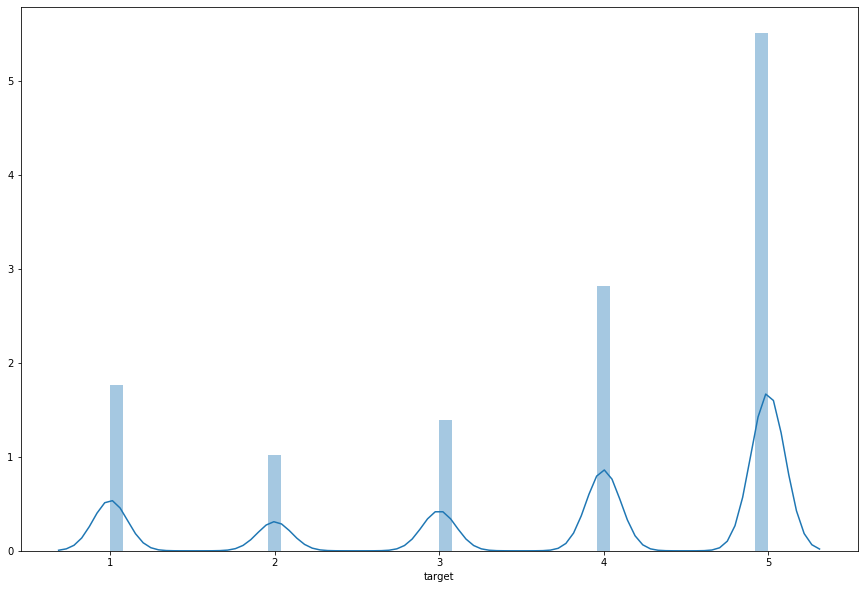

In [16]:
# Visualizing the scores
plt.figure(figsize=(15,10))
plt.tight_layout()
seabornInstance.distplot(dev_set['target'])

In [17]:
# Subset data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [18]:
# Instantiate Regressor and fit data
regressor = LinearRegression()  
regressor.fit(X_train, y_train)

LinearRegression()

In [71]:
coeff_df = pd.DataFrame(regressor.coef_, X.columns, columns=['Coefficient'])  
coeff_df

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [19]:
# Predict on test data
y_pred = regressor.predict(X_test)

In [21]:
# Inspect differences
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df1 = df.head(25)
df1

,Actual,Predicted
0,3.0,2.393469
1,1.0,2.860333
2,3.0,3.368492
3,3.0,3.866089
4,4.0,4.532522
5,4.0,4.747918
6,5.0,3.767960
7,1.0,3.149091
8,5.0,4.119171
9,4.0,4.386377


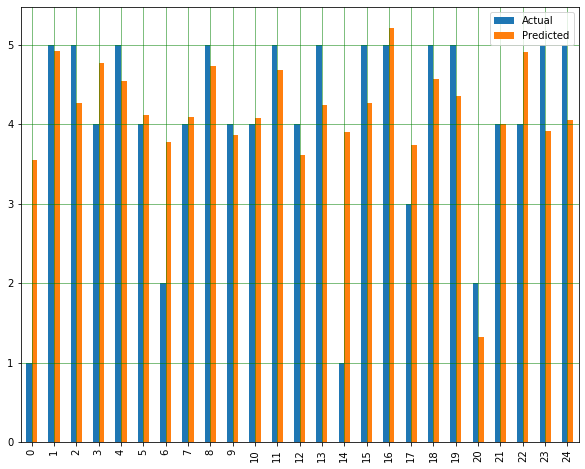

In [89]:
df1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [90]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.8022027692191935
Mean Squared Error: 1.057416512034002
Root Mean Squared Error: 1.0283075960207637


In [13]:
df.head

<bound method NDFrame.head of        Actual  Predicted
0         3.0   3.218530
1         5.0   4.624523
2         3.0   3.305551
3         5.0   4.751817
4         5.0   3.965569
...       ...        ...
59995     2.0   3.093724
59996     5.0   4.361497
59997     3.0   3.660967
59998     4.0   3.174787
59999     4.0   4.580901

[60000 rows x 2 columns]>

In [19]:
def convert_results(prediction):
    if prediction >= 4.5:
        return 5.0
    elif prediction >= 3.5:
        return 4.0
    elif prediction >= 2.5:
        return 3.0
    elif prediction >= 1.5:
        return 2.0
    else:
        return 1.0

In [22]:
df['mapped'] = df['Predicted'].map(convert_results)

In [23]:
df.head

<bound method NDFrame.head of        Actual  Predicted  mapped
0         3.0   2.393469     2.0
1         1.0   2.860333     3.0
2         3.0   3.368492     3.0
3         3.0   3.866089     4.0
4         4.0   4.532522     5.0
...       ...        ...     ...
99995     1.0   1.492866     1.0
99996     3.0   3.934407     4.0
99997     5.0   4.975591     5.0
99998     4.0   3.934913     4.0
99999     3.0   4.234420     4.0

[100000 rows x 3 columns]>

In [24]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(df.Actual, df.mapped, labels=[1.0, 2.0, 3.0, 4.0, 5.0]))

[[ 3851  4660  3257  2210    14]
 [  776  1902  2343  3107    45]
 [  298  1016  2276  7077   438]
 [   77   444  1973 16305  3946]
 [  111   493  2216 27131 14034]]


In [25]:
Counter(df.Actual)

Counter({1.0: 13992, 2.0: 8173, 3.0: 11105, 4.0: 22745, 5.0: 43985})

In [33]:
set(df.Actual)

{1.0, 2.0, 3.0, 4.0, 5.0}

In [34]:
for x in set(df.Actual):
    print(type(x))

<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>


In [39]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

class_names = [1.0, 2.0, 3.0, 4.0, 5.0]
plot_confusion_matrix2(df.Actual, df.mapped, classes=class_names)

TypeError: only integer scalar arrays can be converted to a scalar index

In [38]:
def plot_confusion_matrix2(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


In [37]:
from sklearn.utils.multiclass import unique_labels